# Sentiment Analysis using BERT

BERT (Bidirectionnal Encoder Representations for Transformers) is a “new method of pre-training language representations” developed by Google and released in late 2018.

### Import Libraries and Set the intial variables

In [ ]:
# Import necessary libraries
import sys
sys.path.append("") 

import os

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import regex as re
import string
import json
# import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
# from textwrap import wrap

# Torch ML libraries
# import transformers
from transformers import BertModel, BertTokenizer,BertConfig,  AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

#metrics
# from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

import joblib
import tensorflow as tf
import keras
from pyvi import ViTokenizer

# Misc.
import warnings
warnings.filterwarnings('ignore')

2024-11-24 10:38:21.715248: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-24 10:38:21.804896: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-24 10:38:22.440106: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-11-24 10:38:22.440170: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not l

In [2]:
if torch.cuda.is_available():
    print("CUDA is available.")
else:
    print("Using CPU")

CUDA is available.


In [4]:
RAW_DATASET_PATH = "data/vlsp_sentiment_train.csv"
TEST_DATASET_PATH = "data/vlsp_sentiment_test.csv"
stop_words_path = "vietnamese-stopwords.txt"
MAX_LEN = 90
RANDOM_SEED =42
class_names = ['NEU', 'POS', 'NEG']
n_classes = len(class_names)
BATCH_SIZE = 128
EPOCHS = 15
lr = 1e-5
max_norm = 1.0
best_accuracy = 0
best_loss = 100
patient = 2
patient_count = 0
# Set the model name
BERT_MODEL_NAME = 'trituenhantaoio/bert-base-vietnamese-uncased'
data_path = "data/"
bert_model_path = "model/bert/"
rcnn_model_path = "model/rcnn/"


### Load the data

In [5]:
dataset = pd.read_csv(RAW_DATASET_PATH,  on_bad_lines='skip', delimiter="\t")

In [6]:
dataset.shape

(5100, 2)

We can see that the most relevant column for us is content and replyContent and the score as well.

In [7]:
dataset.columns

Index(['Class', 'Data'], dtype='object')

We can see that we have more positive classes than negative and low number of neutral class. I have kept neutral less to focus more on positive and negative classes. Let's allot classes based on scores now. 

* -1 - negative
* 0 - neutral 
* 1 - positive

In [8]:
dataset.describe()

,Class
count,5100.000000
mean,0.000000
std,0.816577
min,-1.000000
25%,-1.000000
50%,0.000000
75%,1.000000
max,1.000000


In [9]:
dataset=dataset.drop_duplicates("Data")
dataset = dataset.dropna()

In [10]:
dataset["Class"].value_counts()

Class
 0    1697
-1    1693
 1    1672
Name: count, dtype: int64

In [11]:
dataset["Data"].sample(40)

4152    Ôi đẹp quá đi, phải nói là ip 6S giống con này...
3756    Đợi đánh giá thôi thím, giá này quá ổn rồi, có...
3789    Like bác. bản 2 này thêm cái màn hình hiển thị...
1863           Thật là tuyệt vời! Thật không thể tin nổi!
4353    Vậy thì hay ho ở chỗ nào nhỉ? Nếu thế 2K-4K để...
232     pin yếu thì em biết nhưng của em lại còn lỗi p...
1902    Trước tôi đc cô cho 1 em samsung nắp gập rất b...
4420    Ko việc gì phải thêm anh đẹp anh đẳng cấp a có...
2868                                             Mê quá !
1796                                          quá ngon <3
4428     Không vội vàng mua giá cao, giảm giá nhanh thôi.
1996    Chưa dùng note 3 nên không rõ lắm, nói chung c...
4412    Sao nhanh bằng vân tay trên iPhone 6s được nhỉ...
153     Bạn nói chuẩn. Không có gì đặc biệt mà giá ngấ...
358      Nhìn còn xấu hơn cả tuyệt phẩm thiết kế G5. :)))
290     Đẹp đấy nhưng giá khoảng 12tr thôi thì vừa,chứ...
48      Chủ yếu các chức năng hoa lá cành, show hàng l...
2282    Mình x

In [12]:
import regex as re
import string
import json

emoji_pattern = re.compile("["
                u"\U0001F600-\U0001F64F"  # emoticons
                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                u"\U00002702-\U000027B0"
                u"\U000024C2-\U0001F251"
                u"\U0001f926-\U0001f937"
                u'\U00010000-\U0010ffff'
                u"\u200d"
                u"\u2640-\u2642"
                u"\u2600-\u2B55"
                u"\u23cf"
                u"\u23e9"
                u"\u231a"
                u"\u3030"
                u"\ufe0f"
    "]+", flags=re.UNICODE)

def clean_text(text):
    text = text.lower()
    text = re.sub(emoji_pattern, " ", text)
    text = re.sub(r'([a-z]+?)\1+',r'\1', text)
    text = re.sub(r"(\w)\s*([" + string.punctuation + "])\s*(\w)", r"\1 \2 \3", text)
    text = re.sub(r"(\w)\s*([" + string.punctuation + "])", r"\1 \2", text)
    # text = re.sub(r"(\d)([^\d.])", r"\1 \2", text)
    # text = re.sub(r"([^\d.])(\d)", r"\1 \2", text)
    text = re.sub(f"([{string.punctuation}])([{string.punctuation}])+",r"\1", text)
    text = text.strip()
    while text.endswith(tuple(string.punctuation+string.whitespace)):
        text = text[:-1]
    while text.startswith(tuple(string.punctuation+string.whitespace)):
        text = text[1:]
    text = re.sub(r"\s+", " ", text)
    return text

from pyvi import ViTokenizer

def tokenizingText(text):
    return ViTokenizer.tokenize(text)

lookup_dict = { 'sf': 'sản phẩm','cx':'cũng','kg':'kilogam', 'k':'không', 'ko':'không', 'hong':'không', 'kh':'không', 'kt':'kiểm tra', 'ktra':'kiểm tra', 'bt':'biết', 'pít': 'biết', 'píc': 'biết','v': 'với', 'sl': 'số lượng' ,'dk' : 'được', 'dc' : 'được', 'đc' : 'được' ,'chat' : 'chất' ,'okela' : 'tốt' , 'mn' : 'mọi người', 'sp' : 'sản phẩm', 'ib' : 'inbox', 'nt': 'nhắn tin', 'qc': 'quảng cáo', 'sd': 'sử dụng', 'g': 'giờ', 'dv': 'dịch vụ', 'vs': 'với', 'wa': 'qua', 'tgian' :' thời gian', 'tg' :' thời gian', 'tl' : 'trả lời', 'dx' : 'được', 'ntn' : 'như thế này', 'trc' :'trước'}

def text_std(input_text):
    words = input_text.split()
    new_words = []
    for word in words:
        word = re.sub(r'[^\w\s]','', word)
        if word.lower() in lookup_dict:
            word = lookup_dict[word.lower()]
        new_words.append(word)
    new_text = " ".join(new_words)
    return new_text

normalized_string = lambda x: " ".join(x.lower() for x in x.split())

with open(stop_words_path, 'r', encoding='utf-8') as file:
    stop_words = file.read().splitlines()

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

def map_label(label):
    if label == -1:
        return 2  # NEG
    return label  # Keep other values unchanged

In [13]:
dataset["Data"] = dataset["Data"].map(lambda text: clean_text(text))
dataset["Data"] = dataset["Data"].apply(text_std)
# dataset["content"] = dataset["content"].apply(remove_stopwords)
dataset["Data"] = dataset["Data"].apply(normalized_string)
dataset["Data"] = dataset["Data"].apply(tokenizingText)
dataset["Class"] = dataset["Class"].map(map_label)

In [14]:
dataset.head(10)

,Class,Data
0,2,mình đã dùng anywhere thế_hệ đầu quả là đầy th...
1,2,quan_tâm nhất là độ trễ có cao không dùng thi_...
2,2,dag xài con cùi bắp 98k pin trâu mỗi tội đánh ...
3,2,logitech chắc hàng phải tiền triệu trở lên dùn...
4,2,đang xài con m175 cùi mía nhà xài nhiều chuột ...
5,2,đang xài 2 con m185 nút chuột giữa hai con đều...
6,2,con anywhere 1 mình dùng bị double click cũng ...
7,2,hàng cty cấp cấp xong vứt ở nhà xài con xornet...
8,2,magic mouse mà ngon hơn mới_lạ magic mouse chỉ...
9,2,em giống y bác luôn chán bluetoth kinh_hồn 1tr...


## Data Preprocessing

In [15]:


# Build a BERT based tokenizer
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

In [16]:
# Some of the common BERT tokens
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows we’re doing classification
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set 

[SEP] 3
[CLS] 2
[PAD] 0
[UNK] 1


BERT works with fixed-length sequences. We’ll use a simple strategy to choose the max length. Let’s store the token length of each review.

In [17]:
# Store length of each review 
token_lens = []

# Iterate through the content slide
for txt in dataset.Data:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


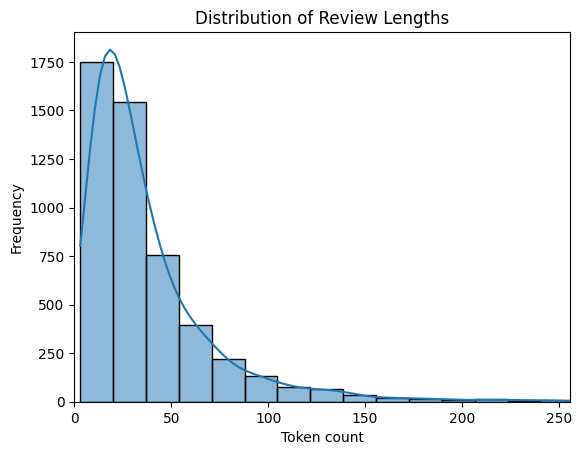

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the distribution of review lengths using histplot
sns.histplot(token_lens, kde=True, bins=30)  # `kde=True` adds the kernel density estimate
plt.xlim([0, 256])
plt.xlabel('Token count')
plt.ylabel('Frequency')
plt.title('Distribution of Review Lengths')
plt.show()


In [19]:
df_train, df_test = train_test_split(dataset, test_size=0.2, random_state=RANDOM_SEED,stratify=dataset['Class'])
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED, stratify=df_test['Class'])
print(df_train.shape, df_val.shape, df_test.shape)

(4049, 2) (506, 2) (507, 2)


In [20]:
from sklearn.utils import shuffle
df_train = pd.concat([df_train, df_val.sample(frac=0.62, random_state=RANDOM_SEED)])
df_train = pd.concat([df_train, df_test.sample(frac=0.5, random_state=RANDOM_SEED)])

df_train = shuffle(df_train, random_state=RANDOM_SEED)

print(df_train.shape, df_val.shape, df_test.shape)

(4617, 2) (506, 2) (507, 2)


In [21]:
df_train=df_train.drop_duplicates("Data")
print(df_train.shape, df_val.shape, df_test.shape)

(4589, 2) (506, 2) (507, 2)


In [22]:
# df_train.to_csv("data/train.csv", index=False)
# df_val.to_csv("data/val.csv", index=False)
# df_test.to_csv("data/test.csv", index=False)

# Create Pytorch Dataset

In [23]:
class GPReviewDataset(Dataset):
    # Constructor Function 
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    # Length magic method
    def __len__(self):
        return len(self.reviews)
    
    # get item magic method
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        
        # Encoded format to be returned 
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [24]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.Data.to_numpy(),
        targets=df.Class.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [25]:
# Create train, test and val data loaders
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [26]:
# Examples 
data = next(iter(train_data_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([128, 90])
torch.Size([128, 90])
torch.Size([128])


## Sentiment Classification with BERT

**Load the dataset**

In [27]:
# Load the basic BERT model 
bert_model = BertModel.from_pretrained(BERT_MODEL_NAME)

In [28]:
# Build the Sentiment Classifier class 
class SentimentClassifier(nn.Module):
    
    # Constructor class 
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(BERT_MODEL_NAME)
        self.drop = nn.Dropout(p=0.5)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        
    
    def forward(self, input_ids, attention_mask):
            bert_output = self.bert(
              input_ids=input_ids,
              attention_mask=attention_mask
            )
            pooled_output = bert_output.pooler_output # Accessing the pooled output
            #  Add a dropout layer
            output = self.drop(pooled_output)
            return self.out(output)

In [29]:
# Instantiate the model and move to classifier
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [30]:
# Optimizer Adam 
optimizer = AdamW(model.parameters(), lr=lr, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the loss function 
loss_fn = nn.CrossEntropyLoss().to(device)

In [31]:
# Function for a single training iteration
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    for i,d in enumerate(data_loader):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        # Backward prop
        loss.backward()
        
        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_norm)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return correct_predictions.double() / n_examples, np.mean(losses)

In [32]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
    
    return correct_predictions.double() / n_examples, np.mean(losses)

In [33]:
history = defaultdict(list)

for epoch in range(EPOCHS):
    
    # Show details 
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)
    
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    print(f"Train loss {train_loss} accuracy {train_acc}")
    
    
    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    
    print(f"Val loss {val_loss} accuracy {val_acc}")
    
    history['train_acc'].append(train_acc.item())
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc.item())
    history['val_loss'].append(val_loss)
    
    # If we beat prev performance
    if val_acc > best_accuracy and best_loss > val_loss:
        model_name = f"{bert_model_path}/model_state_{epoch}.bin"
        torch.save(model.state_dict(), model_name)
        best_accuracy = val_acc
        best_loss = val_loss
    elif(best_loss < val_loss):
        patient_count = patient_count +1
        if (patient_count >= patient):
            print("Early Stop trigger")
            break;

Epoch 1/15
----------
Train loss 1.006845290462176 accuracy 0.49880148180431466
Val loss 0.767149493098259 accuracy 0.6857707509881422
Epoch 2/15
----------
Train loss 0.7678620401355956 accuracy 0.6694268903900632
Val loss 0.6255545765161514 accuracy 0.7450592885375493
Epoch 3/15
----------
Train loss 0.5567699952258004 accuracy 0.7799084767923294
Val loss 0.5584587082266808 accuracy 0.7865612648221343
Epoch 4/15
----------
Train loss 0.3910120816694366 accuracy 0.8559599041185444
Val loss 0.6207530796527863 accuracy 0.8023715415019762
Epoch 5/15
----------
Train loss 0.2803938285344177 accuracy 0.9008498583569405
Val loss 0.5183085203170776 accuracy 0.8517786561264822
Epoch 6/15
----------
Train loss 0.1696488805529144 accuracy 0.9459577249945522
Val loss 0.5666827708482742 accuracy 0.8478260869565217
Early Stop trigger


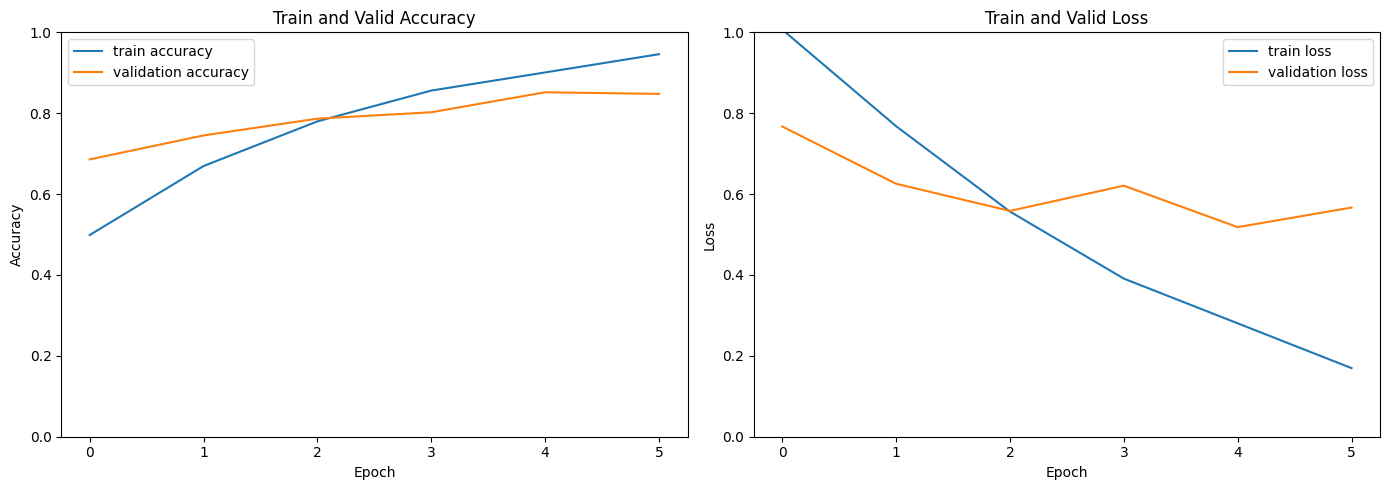

In [34]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot training and validation loss on the first subplot (left)
ax2.plot(history['train_loss'], label='train loss')
ax2.plot(history['val_loss'], label='validation loss')
ax2.set_title('Train and Valid Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend()
ax2.set_ylim([0, 1])

# Plot training and validation accuracy on the second subplot (right)
ax1.plot(history['train_acc'], label='train accuracy')
ax1.plot(history['val_acc'], label='validation accuracy')
ax1.set_title('Train and Valid Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend()
ax1.set_ylim([0, 1])

# Display the plots
plt.tight_layout()
plt.show()


# Test model

In [35]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.834319526627219

In [36]:
# Lưu tokenizer
tokenizer.save_pretrained(bert_model_path)

('model/bert/tokenizer_config.json',
 'model/bert/special_tokens_map.json',
 'model/bert/vocab.txt',
 'model/bert/added_tokens.json')

In [37]:

# Tải cấu hình của mô hình từ tệp config.json
config = BertConfig.from_pretrained(BERT_MODEL_NAME)

# Tải tokenizer từ thư mục chứa các tệp nhị phân đã lưu trữ
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

# Tải mô hình từ thư mục chứa các tệp nhị phân đã lưu trữ
model_bert_sentiment = SentimentClassifier(n_classes = n_classes)
model_bert_sentiment.load_state_dict(torch.load('model/bert/model_state_3.bin'))

# Đảm bảo mô hình ở chế độ evaluation
model_bert_sentiment.eval()
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model_bert_sentiment.to(device)

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

In [38]:
test_acc, _ = eval_model(
  model_bert_sentiment,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.7751479289940829

In [39]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get outouts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values

In [40]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model_bert_sentiment,
    test_data_loader
)

In [41]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

         NEU       0.74      0.74      0.74       170
         POS       0.74      0.87      0.80       167
         NEG       0.87      0.72      0.79       170

    accuracy                           0.78       507
   macro avg       0.78      0.78      0.77       507
weighted avg       0.78      0.78      0.77       507



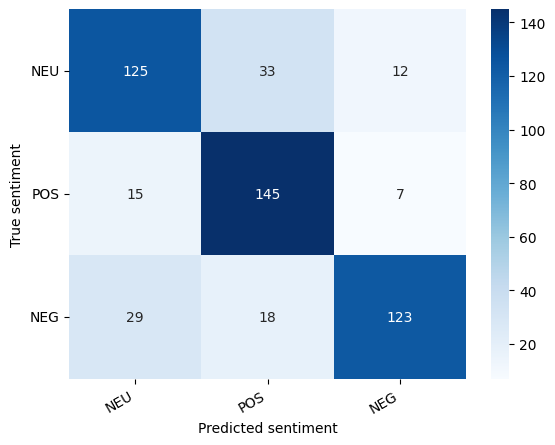

In [42]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [43]:
review_text = "Sản phẩm này cũng bình thường, xài cũng được, không tốt không xấu"

In [44]:
encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
    truncation=True
)

In [45]:
import torch.nn.functional as F

input_ids = encoded_review['input_ids'].to('cuda')
attention_mask = encoded_review['attention_mask'].to('cuda')

output = model_bert_sentiment(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)


probs = F.softmax(output, dim=1)

for i, class_name in enumerate(class_names):
    print(f'{class_name} probability: {probs[0][i].item():.4f}')

# In ra review text và nhãn dự đoán
print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')


NEU probability: 0.0065
POS probability: 0.0116
NEG probability: 0.9818
Review text: Sản phẩm này cũng bình thường, xài cũng được, không tốt không xấu
Sentiment  : NEG


# Real test

In [46]:
test_dataset = pd.read_csv(TEST_DATASET_PATH,  on_bad_lines='skip', delimiter="\t")

In [47]:
test_dataset["Class"] = test_dataset["Class"].map(map_label)

In [48]:
real_test_data_loader = create_data_loader(test_dataset, tokenizer, MAX_LEN, BATCH_SIZE)

In [49]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model_bert_sentiment,
    real_test_data_loader
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [50]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

         NEU       0.66      0.58      0.62       350
         POS       0.64      0.79      0.71       350
         NEG       0.66      0.59      0.62       350

    accuracy                           0.65      1050
   macro avg       0.65      0.65      0.65      1050
weighted avg       0.65      0.65      0.65      1050



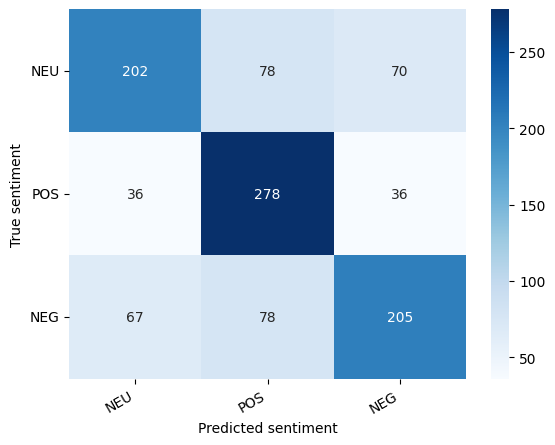

In [51]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment')

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [52]:
def calculate_accuracy(y_test, y_pred):
    """
    Calculate the accuracy given ground truth labels and predictions.

    Args:
        y_test (torch.Tensor): Ground truth labels.
        y_pred (torch.Tensor): Predicted labels.

    Returns:
        float: Accuracy as a percentage.
    """
    # Ensure both tensors are on the same device
    y_test = y_test.to(y_pred.device)
    
    # Compare predictions with ground truth and calculate accuracy
    correct = (y_test == y_pred).sum().item()
    total = y_test.size(0)
    accuracy = correct / total * 100  # Convert to percentage
    return accuracy


In [53]:
accuracy = calculate_accuracy(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 65.24%


# **RCNN**

In [54]:
import tensorflow as tf
print(tf.keras.__version__)
print(tf.__version__)

2.11.0
2.11.0


In [55]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import re
import string
from tqdm import tqdm
import numpy as np
import os 
import gensim
from gensim.models import KeyedVectors
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import sklearn.metrics as metrics
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Flatten, LSTM, Conv1D, MaxPooling1D, Input, Reshape, GRU, Bidirectional, Convolution1D
from keras import Model, models, optimizers

In [56]:
df_train = pd.read_csv('data/train.csv')
df_val = pd.read_csv("data/val.csv")
df_test = pd.read_csv("data/test.csv")

In [57]:
def TokenizingText(text):
    return ViTokenizer.tokenize(text)

In [58]:
df_train['Data']= df_train['Data'].apply(TokenizingText)
df_val['Data']= df_val['Data'].apply(TokenizingText)
df_test['Data']= df_test['Data'].apply(TokenizingText)

In [59]:
X_train = df_train['Data']
X_val = df_val['Data']
X_test = df_test['Data']

Y_train = df_train['Class']
Y_val = df_val['Class']
Y_test = df_test['Class']

## Create tfidf and svd

In [60]:
tfidf_vect = TfidfVectorizer(analyzer='word', max_features=30000)
tfidf_vect.fit(X_train) 
X_train_tfidf =  tfidf_vect.transform(X_train)
X_val_tfidf =  tfidf_vect.transform(X_val)
X_test_tfidf =  tfidf_vect.transform(X_test)

In [61]:
svd = TruncatedSVD(n_components=300, random_state=42)
svd.fit(X_train_tfidf)
X_train_tfidf_svd = svd.transform(X_train_tfidf)
X_val_tfidf_svd = svd.transform(X_val_tfidf)
X_test_tfidf_svd = svd.transform(X_test_tfidf)

In [62]:
tf.keras.backend.clear_session()

In [63]:
from keras.callbacks import EarlyStopping

RCNN_model = Sequential()

RCNN_model.add(Input(shape=(300,)))
RCNN_model.add(Reshape((10, 30)))
RCNN_model.add(Bidirectional(GRU(128, activation='relu', return_sequences=True)))
RCNN_model.add(Convolution1D(100, 3, activation="relu"))
RCNN_model.add(Flatten())
RCNN_model.add(Dense(512, activation='relu'))
RCNN_model.add(Dense(512, activation='relu'))
RCNN_model.add(Dense(128, activation='relu'))
RCNN_model.add(Dense(3, activation='softmax'))
RCNN_model.summary()

RCNN_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3)  

from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_filepath = 'model_weights-{epoch:02d}.weights.h5'

# Define the checkpoint callback to save weights after every 5 epochs
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,  # Save only the weights, not the entire model
    save_freq=1,  # Save after every 5 epochs (since data_generator yields 1 batch per step)
    verbose=1
)

history = RCNN_model.fit(X_train_tfidf_svd, Y_train, validation_data=(X_val_tfidf_svd, Y_val), epochs=5, batch_size=64, callbacks=[early_stop,checkpoint_callback]) 
    
val_predictions = RCNN_model.predict(X_val_tfidf_svd)
test_predictions = RCNN_model.predict(X_test_tfidf_svd)
val_predictions = val_predictions.argmax(axis=-1)
test_predictions = test_predictions.argmax(axis=-1)
    
print("Validation accuracy: ", metrics.accuracy_score(val_predictions, Y_val))
print("Test accuracy: ", metrics.accuracy_score(test_predictions, Y_test))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 10, 30)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 10, 256)          122880    
 l)                                                              
                                                                 
 conv1d (Conv1D)             (None, 8, 100)            76900     
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dense (Dense)               (None, 512)               410112    
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                        

2024-11-24 10:44:17.197257: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-24 10:44:17.243867: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-24 10:44:17.243904: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-24 10:44:17.244348: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other ope

Epoch 1/5


2024-11-24 10:44:19.164213: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-11-24 10:44:20.953290: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2024-11-24 10:44:22.385620: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f0c8c01e190 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-24 10:44:22.385648: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-11-24 10:44:22.390277: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-24 10:44:22.471040: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of 


Epoch 1: saving model to model_weights-01.weights.h5
 1/72 [..............................] - ETA: 7:18 - loss: 1.0984 - accuracy: 0.3125
Epoch 1: saving model to model_weights-01.weights.h5
 2/72 [..............................] - ETA: 5s - loss: 1.1000 - accuracy: 0.3203  
Epoch 1: saving model to model_weights-01.weights.h5
 3/72 [>.............................] - ETA: 4s - loss: 1.0988 - accuracy: 0.3385
Epoch 1: saving model to model_weights-01.weights.h5
 4/72 [>.............................] - ETA: 4s - loss: 1.0997 - accuracy: 0.3242
Epoch 1: saving model to model_weights-01.weights.h5
 5/72 [=>............................] - ETA: 4s - loss: 1.0993 - accuracy: 0.3281
Epoch 1: saving model to model_weights-01.weights.h5
 6/72 [=>............................] - ETA: 4s - loss: 1.0989 - accuracy: 0.3333
Epoch 1: saving model to model_weights-01.weights.h5
 7/72 [=>............................] - ETA: 4s - loss: 1.0987 - accuracy: 0.3326
Epoch 1: saving model to model_weights-01.w

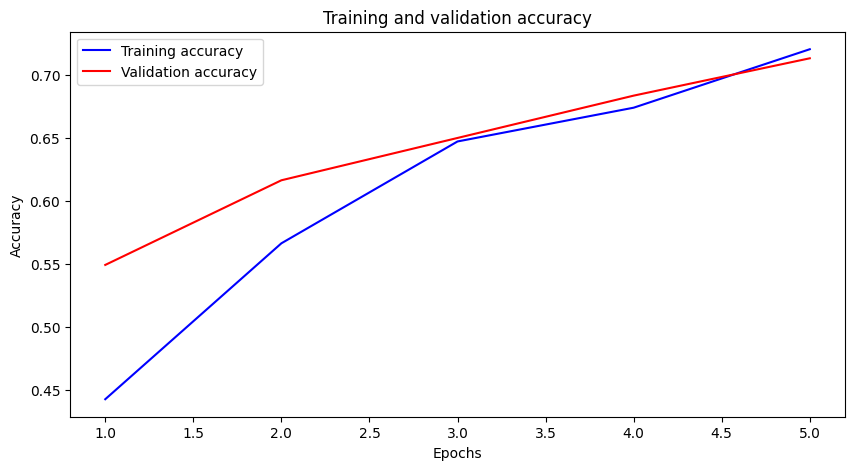

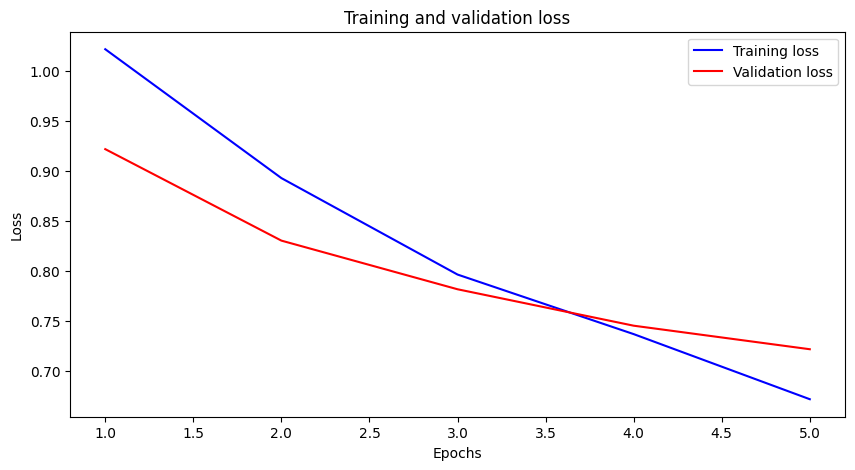

In [64]:
import matplotlib.pyplot as plt

# Lấy các giá trị từ lịch sử huấn luyện
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_accuracy) + 1)

# Vẽ đồ thị độ chính xác
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Vẽ đồ thị mất mát
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [65]:
from sklearn.metrics import classification_report

# Tính toán classification report trên tập dữ liệu kiểm tra
class_report = classification_report(Y_test, test_predictions, target_names=class_names)

# Hiển thị classification report
print("Classification Report:\n", class_report)


Classification Report:
               precision    recall  f1-score   support

         NEU       0.68      0.55      0.61       170
         POS       0.74      0.75      0.75       167
         NEG       0.66      0.77      0.71       170

    accuracy                           0.69       507
   macro avg       0.69      0.69      0.69       507
weighted avg       0.69      0.69      0.69       507



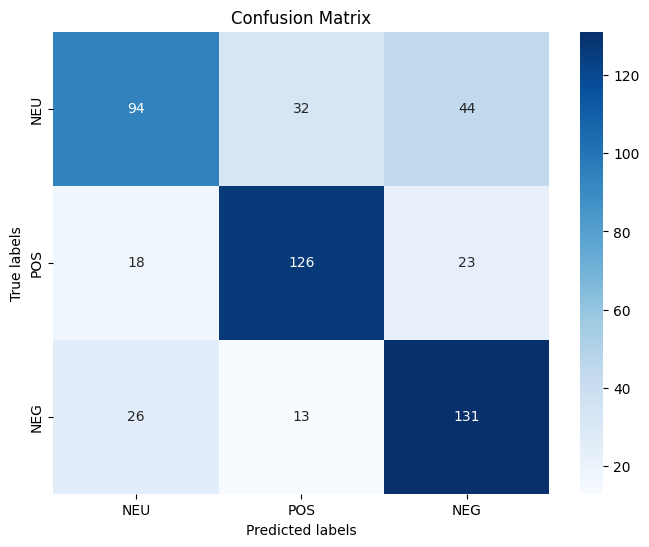

In [66]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Tính toán confusion matrix trên tập dữ liệu kiểm tra
conf_matrix = confusion_matrix(Y_test, test_predictions)

# Hiển thị confusion matrix bằng seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [73]:
# Đánh giá mô hình trên tập test
test_loss, test_accuracy = RCNN_model.evaluate(X_test_tfidf_svd, Y_test)

print("Test Accuracy:", test_accuracy)
print("Test Loss:", test_loss)


16/16 [==============================] - 0s 16ms/step - loss: 0.7103 - accuracy: 0.6963
Test Accuracy: 0.6962524652481079
Test Loss: 0.7102755904197693


In [74]:
for i in range(len(RCNN_model.weights)):
    RCNN_model.weights[i]._handle_name = RCNN_model.weights[i].name + "_" + str(i)

In [75]:
from joblib import dump
RCNN_model.save(f"{rcnn_model_path}/RCNN_model.h5")
dump(tfidf_vect, f"{rcnn_model_path}/tfidf_model.joblib")
dump(svd, f"{rcnn_model_path}/svd_model.joblib")


['model/rcnn//svd_model.joblib']

In [76]:
svd = joblib.load(f"{rcnn_model_path}/svd_model.joblib")
tfidf = joblib.load(f"{rcnn_model_path}/tfidf_model.joblib")
RCNN_model.load_weights(f"{rcnn_model_path}model_weights-05.weights.h5")


In [77]:
def sentiment_predict(model, text, class_names:list):
    """
    Predict sentiment for a given text using the RCNN model.

    Args:
        text (str): Input text for sentiment analysis.
    
    Returns:
        None
    """
    # Ensure the input is wrapped in a list
    text_tfidf = tfidf.transform([text])  # Wrap the string in a list
    text_svd = svd.transform(text_tfidf)
    predictions = RCNN_model.predict(text_svd)
    predicted_class_index = np.argmax(predictions)
    predicted_class = class_names[predicted_class_index]
    probabilities = prediction[0]

    return predicted_class, probabilities

In [78]:
sentiment_predict(model=RCNN_model, text = "Sản phẩm này rất tốt, tôi rất thích nó", class_names=class_names)

1/1 [==============================] - 0s 19ms/step


('POS', tensor(2, device='cuda:0'))